# Stock Analysis Project: Asianpaints


## Introduction

This project focuses on analyzing the stock performance of Asianpaint. The analysis includes data collection, preprocessing, visualization, and the application of various analytical techniques to derive insights. The data was collected and various operations were performed using the Alice Blue API.


## Import Libraries

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pya3 import Aliceblue
from nsetools import Nse
from datetime import datetime, timedelta
import holidays
import quantstats as qs


## Function to Get User Credentials

In [13]:
def get_user_credentials():
    user_id = input("Enter your user ID: ")
    api_key = input("Enter your API key: ")
    return user_id, api_key


## Main Function for Stock Analysis

Enter your user ID:  1141826
Enter your API key:  YOEFYiAmppZEG2NiMjh1oIafyiyO08HQ59mHyE21peR3qJQSJNJ0WChk6TGEbTG5BqAE2sdpty41RXXiktHNOJW6nCqCouYNairMhkooiGtczYQfmESf4kU1FzBmqqfV



Top 3 Months with Highest Average Return:
July: 8.09%
December: 4.31%
May: 3.54%


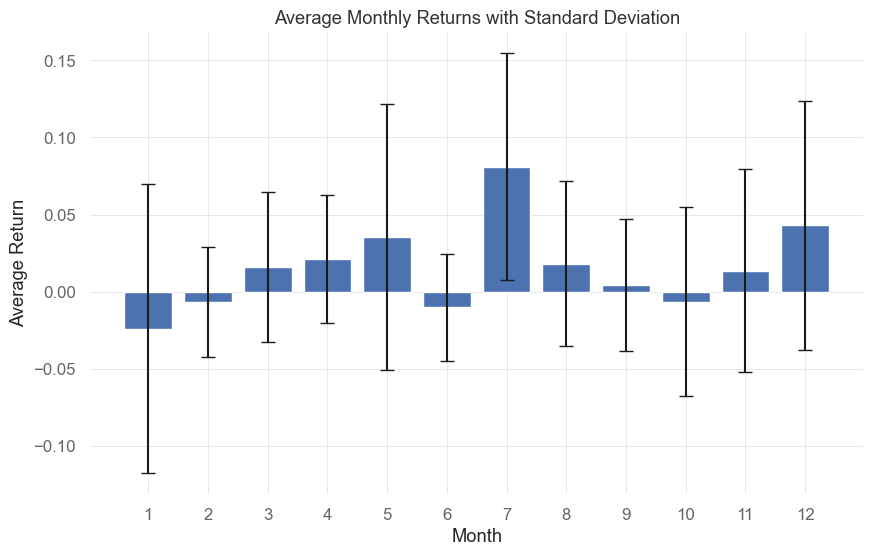

In [15]:
def main():
    # Get user credentials
    user_id, api_key = get_user_credentials()
    
    # Create an instance of Aliceblue
    alice = Aliceblue(user_id=user_id, api_key=api_key)
    
    # Get session ID
    alice.get_session_id()
    
    # Create an instance of Nse
    nse = Nse()
    
    # Define instrument and time range for historical data
    instrument = alice.get_instrument_by_token('NSE', 236)
    from_datetime = datetime(2014, 7, 1)
    to_datetime = datetime(2024, 7, 1)
    interval = "D"
    
    # Fetch historical data
    historical_data = alice.get_historical(instrument, from_datetime, to_datetime, interval)
    
    # Create DataFrame
    df = pd.DataFrame(historical_data)
    
    # Preprocess data
    df['datetime'] = pd.to_datetime(df['datetime'], format='%Y-%m-%d %H:%M:%S')
    df.set_index('datetime', inplace=True)
    df['pct'] = df['close'].pct_change()
    df.columns = df.columns.str.strip()
    df = df.drop(columns=['open', 'high', 'low', 'close', 'volume']).dropna()
    
    # Resample data to get monthly percentage change
    monthly_pct_change = df['pct'].resample('M').sum()
    df = monthly_pct_change.to_frame(name='pct')
    
    # Extract year and month for analysis
    df['year'] = df.index.year
    df['month'] = df.index.month
    
    # Create pivot table
    pivot_table = df.pivot_table(values='pct', index='year', columns='month', aggfunc='mean')
    
    # Calculate average monthly returns and standard deviation
    monthly_avg = df.groupby('month')['pct'].mean()
    monthly_std = df.groupby('month')['pct'].std()

    # Combine into a single DataFrame
    monthly_stats = pd.DataFrame({
        'Average Return': monthly_avg,
        'Standard Deviation': monthly_std
    }).sort_values(by='Average Return', ascending=False)
    
    # Get top three months
    top_months = monthly_stats.head(3)
    month_names = top_months.index.map(lambda x: datetime(1900, x, 1).strftime('%B'))

    # Print top 3 months with highest average return
    print("\nTop 3 Months with Highest Average Return:")
    for month, name in zip(top_months.index, month_names):
        print(f"{name}: {monthly_stats.loc[month, 'Average Return']:.2%}")

    # Plot average monthly returns with standard deviation
    plt.figure(figsize=(10, 6))
    plt.bar(monthly_stats.index, monthly_stats['Average Return'], yerr=monthly_stats['Standard Deviation'], capsize=5)
    plt.xlabel('Month')
    plt.ylabel('Average Return')
    plt.title('Average Monthly Returns with Standard Deviation')
    plt.xticks(monthly_stats.index)
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    main()


In [16]:
# Analyzing Portfolio Performance with Quantstats
%matplotlib inline
import quantstats as qs


## Automated Analysis of Historical Stock Data Using Quantstats

In [14]:

import re
import io
import contextlib



def parse_metrics(report):
    metrics = {}
    lines = report.split('\n')
    for line in lines:
        match = re.match(r'(.+?)\s+([\d\.\-\%]+)', line)
        if match:
            key, value = match.groups()
            metrics[key.strip()] = value.strip()
    return metrics

def evaluate_stock(metrics):
    criteria = {
        'CAGR﹪': 20,           # Compound Annual Growth Rate
        'Sharpe': 1,           # Sharpe Ratio
        'Sortino': 1           # Sortino Ratio
    }
    
    # Extract relevant metrics
    cagr = float(metrics['CAGR﹪'].strip('%'))
    sharpe = float(metrics['Sharpe'])
    sortino = float(metrics['Sortino'])
    
    # Evaluate criteria
    if (cagr > criteria['CAGR﹪'] and
        sharpe > criteria['Sharpe'] and
        sortino > criteria['Sortino']):
        return "Buy"
    else:
        return "Do Not Buy"

def main():
    # Get user credentials
    user_id, api_key = get_user_credentials()
    
    # Create an instance of Aliceblue
    alice = Aliceblue(user_id=user_id, api_key=api_key)
    
    # Get session ID
    alice.get_session_id()
    
    # Create an instance of Nse
    nse = Nse()
    
    # Define instrument and time range for historical data
    instrument = alice.get_instrument_by_token('NSE', 19913)
    from_datetime = datetime(2014, 7, 1)
    to_datetime = datetime(2024, 7, 1)
    interval = "D"
    
    # Fetch historical data
    historical_data = alice.get_historical(instrument, from_datetime, to_datetime, interval)
    
    # Create DataFrame
    df = pd.DataFrame(historical_data)
    
    # Preprocess data
    df['datetime'] = pd.to_datetime(df['datetime'], format='%Y-%m-%d %H:%M:%S')
    df.set_index('datetime', inplace=True)
    df['pct'] = df['close'].pct_change()
    df.columns = df.columns.str.strip()
    df = df.drop(columns=['open', 'high', 'low', 'close', 'volume']).dropna()
    
    # Capture the metrics report as a string
    buffer = io.StringIO()
    with contextlib.redirect_stdout(buffer):
        qs.reports.metrics(mode='basic|full', returns=df['pct'])
    report = buffer.getvalue()
    
    # Print the captured report in the notebook for debugging
    print("Captured Report:\n", report)
    
    # Parse the metrics from the report
    metrics = parse_metrics(report)
    
    # Print the parsed metrics for debugging
    print("Parsed Metrics:", metrics)
    
    # Make a buy recommendation based on metrics
    recommendation = evaluate_stock(metrics)
    print("Recommendation:", recommendation)

if __name__ == "__main__":
    main()


Enter your user ID:  1141826
Enter your API key:  S8P2vt2tEjQYFRszZiA5IWNJKOHSd5RS7tnzvWh7EEbEIvDbpvpUXoHdujp2YRISlL8kahDFe5BlMyv2yEznQY6NEC1V15PGPeGVxjXc5Zo7Mmzc9fhTgQAE2sXt7p1v


Captured Report:
                     Strategy
------------------  ----------
Start Period        2017-03-22
End Period          2024-07-01
Risk-Free Rate      0.0%
Time in Market      100.0%

Cumulative Return   638.14%
CAGR﹪              31.59%

Sharpe              1.07
Sortino             1.7
Sortino/√2          1.2
Omega               1.21

Max Drawdown        -39.32%
Longest DD Days     987

Gain/Pain Ratio     0.21
Gain/Pain (1M)      1.34

Payoff Ratio        1.16
Profit Factor       1.21
Common Sense Ratio  1.46
CPC Index           0.72
Tail Ratio          1.21
Outlier Win Ratio   3.92
Outlier Loss Ratio  3.79

MTD                 0.41%
3M                  4.65%
6M                  16.0%
YTD                 16.0%
1Y                  21.77%
3Y (ann.)           12.62%
5Y (ann.)           26.77%
10Y (ann.)          31.59%
All-time (ann.)     31.59%

Avg. Drawdown       -6.33%
Avg. Drawdown Days  55
Recovery Factor     16.23
Ulcer Index         0.18
Serenity Index      2.22

Parsed

In [ ]:
qs.reports.full(loaded_df['pct'])